In [8]:
import cv2
import threading
import numpy as np
from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent
from pylablib.devices import uc480  # uc480 DLLs needed for Thorlabs camera
import matplotlib.pyplot as plt
import argparse
import h5py
import time

In [2]:
class ThorlabsCam:
    def __init__(self):
        self.cam = uc480.UC480Camera()
        print('initialized frame based camera ')

    def start(self):
        self.cam.start_acquisition()

    def get_frame(self):
        frame = self.cam.snap()
        return frame

    def stop(self):
        self.cam.stop_acquisition()
        self.cam.close()

### Test

In [9]:
frame_cam.stop()

initialized frame based camera 


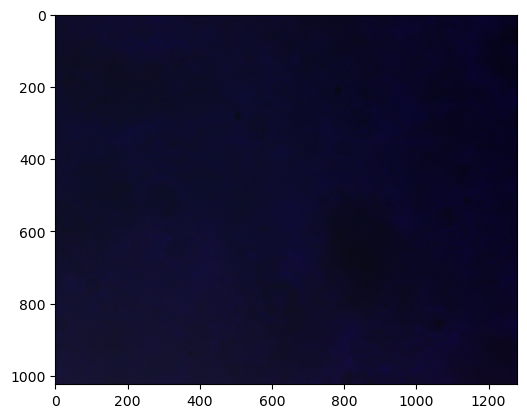

In [10]:
frame_cam=ThorlabsCam()
frame_cam.start()
time.sleep(1)
frame=frame_cam.get_frame()
frame_cam.stop()
plt.imshow(frame)

## Event based camera

In [11]:
def parse_args():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(description='Metavision SDK Get Started sample.',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument(
        '-i', '--input-event-file', dest='event_file_path', default="",
        help="Path to input event file (RAW or HDF5). If not specified, the camera live stream is used. "
        "If it's a camera serial number, it will try to open that camera instead.")
    args,unknown = parser.parse_known_args()
    return args

In [3]:
args = parse_args()

# Events iterator on Camera or event file
mv_iterator = EventsIterator(input_path=args.event_file_path, delta_t=1000)
height, width = mv_iterator.get_size()  # Camera Geometry

# Window - Graphical User Interface
with Window(title="Metavision SDK Get Started", width=width, height=height, 
            mode=BaseWindow.RenderMode.BGR) as window:
    def keyboard_cb(key, scancode, action, mods):
        if action != UIAction.RELEASE:
            return
        if key == UIKeyEvent.KEY_ESCAPE or key == UIKeyEvent.KEY_Q:
            window.set_close_flag()

    window.set_keyboard_callback(keyboard_cb)

    # Event Frame Generator
    event_frame_gen = PeriodicFrameGenerationAlgorithm(sensor_width=width, sensor_height=height,
                                                       accumulation_time_us=100)

    def on_cd_frame_cb(ts, cd_frame):
        window.show(cd_frame)

    event_frame_gen.set_output_callback(on_cd_frame_cb)

    # Process events
    while not window.should_close():
        for evs in mv_iterator:
            # Dispatch system events to the window
            EventLoop.poll_and_dispatch()
            
            if window.should_close():
                break

            event_frame_gen.process_events(evs)

# Cleanup
mv_iterator.__del__()


In [ ]:
class PropheseeCam_in:
    def __init__(self):
        self.args = parse_args()
    def start_iteration(self):
        self.mv_iterator = EventsIterator(input_path=self.args.event_file_path, delta_t=1000)
    def stop(self):
        evs=event_cam.mv_iterator
        self.mv_iterator.__del__()
        return evs

In [12]:
args = parse_args()

In [13]:
class PropheseeCam:
    def __init__(self, args):
        self.args = args
        self.events = []
        self.mv_iterator = None
        self.window = None
        self.close=False

    def start(self):
        self.mv_iterator = EventsIterator(input_path=self.args.event_file_path, delta_t=1000)
        height, width = self.mv_iterator.get_size()
        with Window(title="Metavision SDK Get Started", width=width, height=height, 
                    mode=BaseWindow.RenderMode.BGR) as window:
            self.window = window

            def keyboard_cb(key, scancode, action, mods):
                if action != UIAction.RELEASE:
                    return
                if key == UIKeyEvent.KEY_ESCAPE or key == UIKeyEvent.KEY_Q:
                    window.set_close_flag()

            window.set_keyboard_callback(keyboard_cb)

            # Event Frame Generator
            event_frame_gen = PeriodicFrameGenerationAlgorithm(sensor_width=width, sensor_height=height,
                                                               accumulation_time_us=100)

            def on_cd_frame_cb(ts, cd_frame):
                window.show(cd_frame)

            event_frame_gen.set_output_callback(on_cd_frame_cb)

            # Process events
            while not window.should_close():
                for evs in self.mv_iterator:
                    # Dispatch system events to the window
                    EventLoop.poll_and_dispatch()

                    if window.should_close():
                        self.close=True
                        break

                    # Store events
                    self.events.extend(evs)

                    # Process the events
                    event_frame_gen.process_events(evs)

    def cleanup(self):
        if self.mv_iterator is not None:
            del self.mv_iterator
            self.mv_iterator = None
        if self.window is not None:
            self.window.set_close_flag()
            self.window = None

    def stop(self):
        self.cleanup()
        return self.events
    
    def save_events(self):
        events=self.events
        filename="events_data.h5"
        x = [ev[0] for ev in events]
        y = [ev[1] for ev in events]
        p = [ev[2] for ev in events]
        t = [ev[3] for ev in events]

        with h5py.File(filename, "w") as f:
            cd_group = f.create_group("CD")
            cd_group.create_dataset("events/x", data=np.array(x))
            cd_group.create_dataset("events/y", data=np.array(y))
            cd_group.create_dataset("events/p", data=np.array(p))
            cd_group.create_dataset("events/t", data=np.array(t))




In [7]:
event_c=PropheseeCam(args)

In [8]:
event_c.start()

In [9]:
event_c.save_events()

In [14]:
def load_data(filename):
    with h5py.File(filename, "r") as f:
        evts = f["CD"]["events"]
        x=np.array(evts['x'])
        y=np.array(evts['y'])
        p=np.array(evts['p'])
        t=np.array(evts['t']) #microsegundos
        print(evts['x'])
    return x,y,p,t
#x,y,p,t=load_data("events_data.h5")

## threading

In [19]:
import threading
import time
import os
import cv2

class ThorlabsCam:
    def __init__(self):
        notebook_dir = os.getcwd()
        self.save_folder = os.path.join(notebook_dir, "frames")
        if not os.path.exists(self.save_folder):
            os.makedirs(self.save_folder)

        self.cam = uc480.UC480Camera()
        self.is_acquiring = False
        self.frame_count = 0
        self.save_thread = None

    def start_acquisition(self):
        try:
            self.is_acquiring = True
            self.cam.start_acquisition()
            print("Thorlabs acquisition started")
        except uc480LibError as e:
            print(f"Error starting Thorlabs acquisition: {e}")
            self.is_acquiring = False

    def stop_acquisition(self):
        try:
            self.is_acquiring = False
            self.cam.stop_acquisition()
            print("Thorlabs acquisition stopped")
        except uc480LibError as e:
            print(f"Error stopping Thorlabs acquisition: {e}")

    def save_frames(self):
        last_time = None
        while self.is_acquiring:
            try:
                frame = self.cam.snap()
                time_frame = time.time()
                if frame is not None:
                    filename = os.path.join(self.save_folder, f"frame_{self.frame_count}.png")
                    cv2.imwrite(filename, frame)
                    
                    if last_time is not None:
                        print(f'Time between frames: {time_frame - last_time:.4f} seconds')
                    
                    last_time = time_frame
                    self.frame_count += 1
                    print(f"Saved frame {self.frame_count}")
                    
                    time.sleep(1 / 15)  # Delay to achieve 15 FPS
                else:
                    print("Failed to capture frame")

    def start_saving(self):
        self.save_thread = threading.Thread(target=self.save_frames)
        self.save_thread.start()
        print("Thorlabs frame saving started")

    def stop_saving(self):
        self.is_acquiring = False
        if self.save_thread:
            self.save_thread.join()
        print("Thorlabs frame saving stopped")


IndentationError: unexpected unindent (976477477.py, line 56)

In [ ]:
class MultiCameras:
    def __init__(self, prophesee_args):
        self.prophesee_cam = PropheseeCam(prophesee_args)
        self.thorlabs_cam = ThorlabsCam()
        self.prophesee_thread = None
        self.thorlabs_thread = None

    def start(self):
        self.prophesee_thread = threading.Thread(target=self.prophesee_cam.start)
        self.thorlabs_thread = threading.Thread(target=self.thorlabs_cam.start_acquisition)

        self.prophesee_thread.start()
        self.thorlabs_thread.start()
        self.thorlabs_cam.start_saving()  # Start saving frames from Thorlabs camera

    def stop(self):
        self.prophesee_cam.stop()
        self.prophesee_cam.save_events()
        
        self.thorlabs_cam.stop_acquisition()
        self.thorlabs_cam.stop_saving()
        
        if self.prophesee_thread:
            self.prophesee_thread.join()
        if self.thorlabs_thread:
            self.thorlabs_thread.join()

    def wait_for_timeout(self, timeout):
        time.sleep(timeout)
        self.stop()


# Example usage:
if __name__ == "__main__":
    multicam = MultiCameras(args)
    multicam.start()
    multicam.wait_for_timeout(5) 


In [8]:
x,y,p,t=load_data("events_data.h5")

<HDF5 dataset "x": shape (31032,), type "<u2">


In [9]:
t

array([ 1119,  1119,  1119, ..., 31997, 31999, 31999], dtype=int64)

In [10]:
t.min()/1e6

0.001119

In [11]:
t.max()/1e3

31.999

In [12]:
1/15

0.06666666666666667

In [13]:
0.066*6

0.396